# Housing price predictions

Data source: https://www.kaggle.com/datasets/camnugent/california-housing-prices/

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../')
housing = pd.read_csv('data/external/housing.csv')

In [2]:
len_orig = housing.shape[0]
print(f'Number of examples in the dataset: {len_orig}')
print(f'Number of features in the dataset: {housing.shape[1]}')
print(f'---------------------------------------')

housing.info()

Number of examples in the dataset: 20640
Number of features in the dataset: 10
---------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [3]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


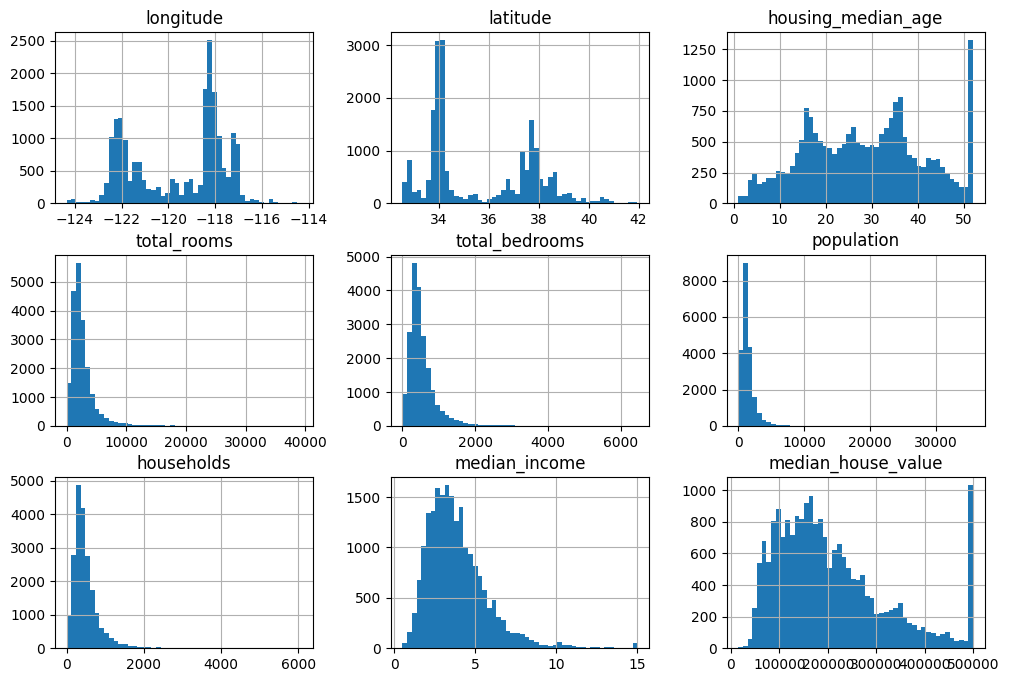

In [4]:
housing.hist(figsize=(12,8), bins=50)
plt.show()

# Exploratory Data Analysis

In [5]:
# Checking missing data
housing.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [6]:
# Process missing data
threshold = len(housing) * 0.05
cols_to_drop = housing.columns[housing.isna().sum() <= threshold]
housing.dropna(subset=cols_to_drop, inplace=True)

housing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20433 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20433 non-null  float64
 1   latitude            20433 non-null  float64
 2   housing_median_age  20433 non-null  float64
 3   total_rooms         20433 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20433 non-null  float64
 6   households          20433 non-null  float64
 7   median_income       20433 non-null  float64
 8   median_house_value  20433 non-null  float64
 9   ocean_proximity     20433 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.7+ MB


In [7]:
house_value_cap = housing['median_house_value'].max()
house_age_cap = housing['housing_median_age'].max()

housing = housing[(housing['median_house_value'] < house_value_cap) & (housing['housing_median_age'] < house_age_cap)]

In [8]:
len_eda = housing.shape[0]

print(f'Number of examples in the dataset: {len_eda}')
print(f'Percentage of the original dataset: {(100 * len_eda / len_orig):.2f}%')
print(f'---------------------------------------')

housing.info()

Number of examples in the dataset: 18379
Percentage of the original dataset: 89.05%
---------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 18379 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           18379 non-null  float64
 1   latitude            18379 non-null  float64
 2   housing_median_age  18379 non-null  float64
 3   total_rooms         18379 non-null  float64
 4   total_bedrooms      18379 non-null  float64
 5   population          18379 non-null  float64
 6   households          18379 non-null  float64
 7   median_income       18379 non-null  float64
 8   median_house_value  18379 non-null  float64
 9   ocean_proximity     18379 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.5+ MB


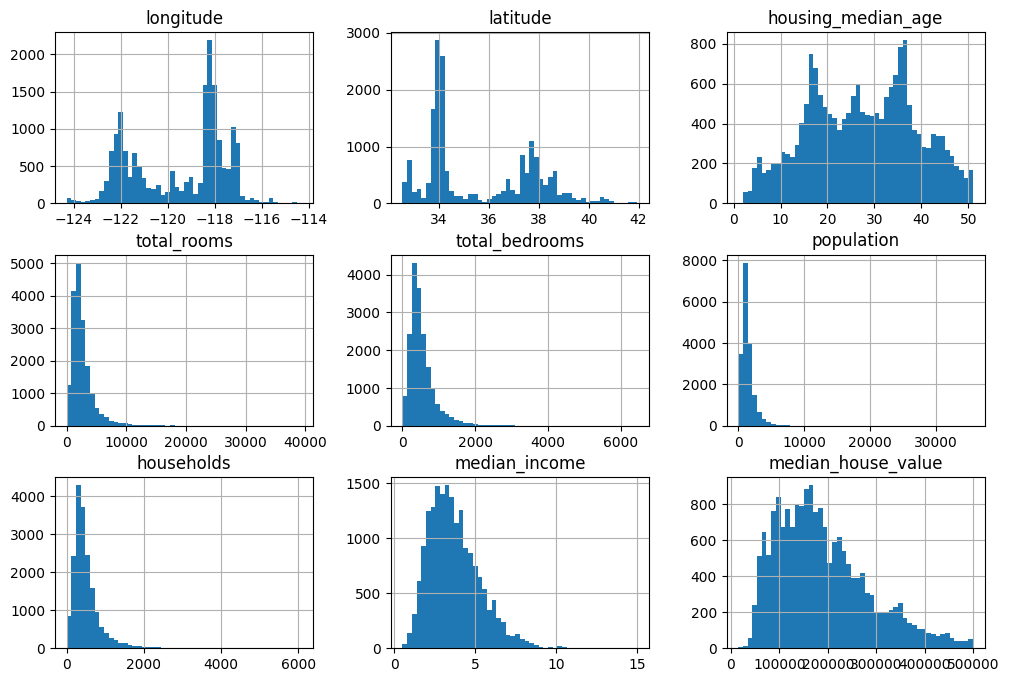

In [9]:
housing.hist(figsize=(12,8), bins=50)
plt.show()

## Data preprocessing

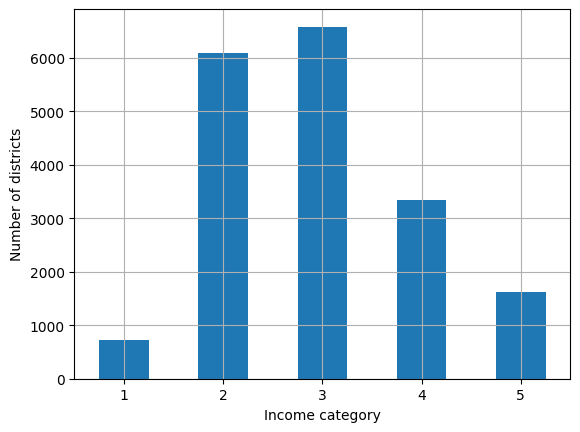

In [10]:
# Create an income category for stratification
housing['income_cat'] = pd.cut(housing['median_income'],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

# Prepare training and testing datasets
from sklearn.model_selection import train_test_split

strat_train_set, strat_test_set = train_test_split(housing, 
                                                   test_size=0.2, 
                                                   stratify=housing['income_cat'], 
                                                   random_state=1)

for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)


strat_train_set.to_csv('data/processed/train_set.csv')
strat_test_set.to_csv('data/processed/test_set.csv')

In [11]:
housing = strat_train_set.copy()

In [12]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14703 entries, 1751 to 17581
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           14703 non-null  float64
 1   latitude            14703 non-null  float64
 2   housing_median_age  14703 non-null  float64
 3   total_rooms         14703 non-null  float64
 4   total_bedrooms      14703 non-null  float64
 5   population          14703 non-null  float64
 6   households          14703 non-null  float64
 7   median_income       14703 non-null  float64
 8   median_house_value  14703 non-null  float64
 9   ocean_proximity     14703 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.2+ MB


In [13]:
X_train = strat_train_set.drop("median_house_value", axis=1)
Y_train = strat_train_set["median_house_value"].copy()

X_test = strat_test_set.drop("median_house_value", axis=1)
Y_test = strat_test_set["median_house_value"].copy()

In [14]:
# To set visibility of pipelines
from sklearn.impute import SimpleImputer
from sklearn import set_config
set_config(display="diagram")

In [15]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import FunctionTransformer, KBinsDiscretizer, OneHotEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder

In [16]:
log_pipeline = make_pipeline(
    KNNImputer(),
    FunctionTransformer(np.log1p, feature_names_out="one-to-one"),
    MinMaxScaler(feature_range=(0, 1)))

In [17]:
one_hot_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder())

In [18]:
default_num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    MinMaxScaler(feature_range=(0, 1)))

In [19]:
preprocessing = ColumnTransformer(
    [
        ("log", log_pipeline, ['total_rooms', 'total_bedrooms', 'population', 'households']),
        ("one_hot", one_hot_pipeline, ["ocean_proximity"]),
    ],
remainder=default_num_pipeline,
force_int_remainder_cols=False,
)

preprocessing

ColumnTransformer(force_int_remainder_cols=False,
                  remainder=Pipeline(steps=[('simpleimputer',
                                             SimpleImputer(strategy='median')),
                                            ('minmaxscaler', MinMaxScaler())]),
                  transformers=[('log',
                                 Pipeline(steps=[('knnimputer', KNNImputer()),
                                                 ('functiontransformer',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<ufunc 'log1p'>)),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['total_rooms', 'total_bedrooms', 'population',
                                  'households']),
                                ('one_hot',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder())]),
                                 ['ocean_proximity'])])

In [20]:
X_train_array = preprocessing.fit_transform(X_train)
X_train_df = pd.DataFrame(X_train_array, columns=preprocessing.get_feature_names_out(), index=X_train.index)
X_train_df.head()

,log__total_rooms,log__total_bedrooms,log__population,log__households,one_hot__ocean_proximity_<1H OCEAN,one_hot__ocean_proximity_INLAND,one_hot__ocean_proximity_ISLAND,one_hot__ocean_proximity_NEAR BAY,one_hot__ocean_proximity_NEAR OCEAN,remainder__longitude,remainder__latitude,remainder__housing_median_age,remainder__median_income
1751,0.690977,0.683865,0.603349,0.674464,0.0,0.0,0.0,1.0,0.0,0.197197,0.574920,0.42,0.116660
12703,0.877900,0.925195,0.788804,0.910368,0.0,1.0,0.0,0.0,0.0,0.289289,0.642933,0.32,0.139626
16555,0.480321,0.376713,0.354799,0.364113,0.0,1.0,0.0,0.0,0.0,0.299299,0.560043,0.70,0.182273
17946,0.737686,0.726240,0.629672,0.715487,1.0,0.0,0.0,0.0,0.0,0.234234,0.509033,0.50,0.256114
12730,0.639251,0.543394,0.499575,0.556048,0.0,1.0,0.0,0.0,0.0,0.295295,0.642933,0.56,0.332713


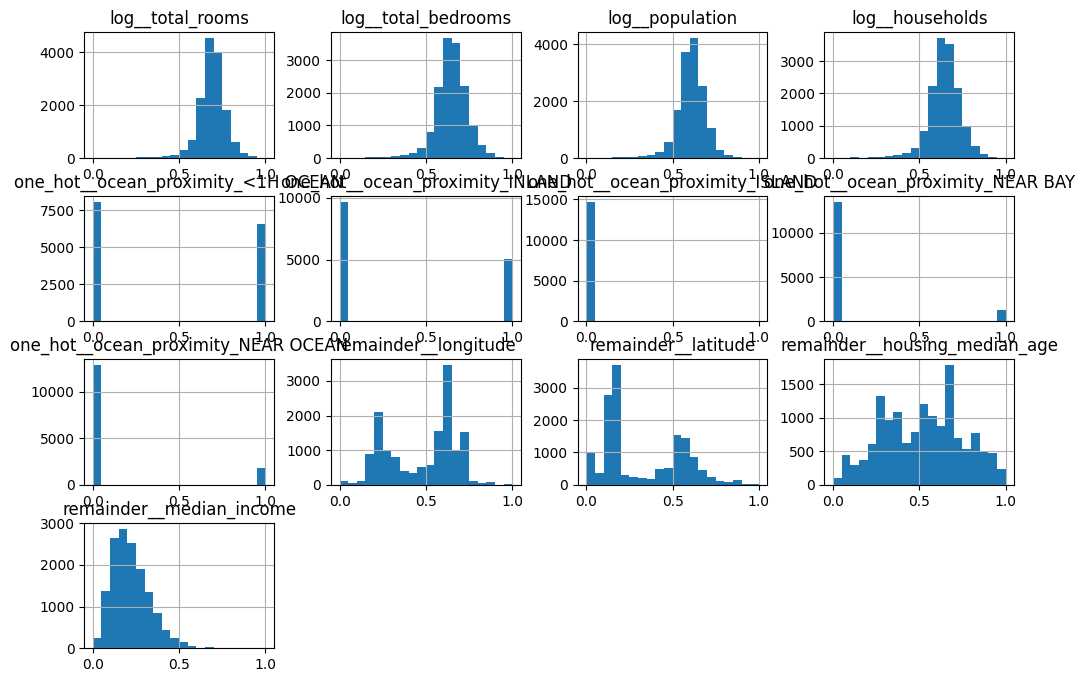

In [21]:
X_train_df.hist(figsize=(12,8), bins=20)
plt.show()

## Linear regression

In [22]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(X_train, Y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('minmaxscaler',
                                                              MinMaxScaler())]),
                                   transformers=[('log',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log1p'>)),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['total_rooms',
                                                   'total_bedrooms',
                                                   'population',
                                                   'households']),
                                                 ('one_hot',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  ['ocean_proximity'])])),
                ('linearregression', LinearRegression())])

In [23]:
Yhat_train = lin_reg.predict(X_train)
print(Yhat_train[:5].round(-2))
print(Y_train.iloc[:5].values)

[168200. 154700. 135500. 283200. 209300.]
[120800.  99100. 179200. 288300. 265700.]


In [24]:
from sklearn.metrics import root_mean_squared_error
lin_rmse = root_mean_squared_error(Y_train, Yhat_train)

lin_rmse

np.float64(56878.64368335498)